In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics
import pandas as pd
import re
import warnings
import random
import matplotlib
from tqdm.notebook import tqdm
from matplotlib.patches import Patch
from scipy.stats import linregress, spearmanr
import analysis_utils 
from copy import deepcopy
import importlib

# path to repository folder (data is stored here as well)
path = '..'
preds_loc = os.path.join(path, 'data', 'analysis', 's461_analysis.csv')

# default plotting settings
font = {'size'   : 18}
matplotlib.rc('font', **font)

# notebook display options
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 300

remap_names = analysis_utils.remap_names
remap_names_2 = analysis_utils.remap_names_2

db = pd.read_csv(preds_loc).set_index(['uid', 'uid2'])

Original unique mutations: 461
['KORPMD_dir', 'CartddgD_dir', 'FoldXD_dir', 'EvoD_dir', 'DDGunD_dir', 'ACDCNND_dir', 'ACDC-NN-Seq_dir', 'ACDC-NN-Seq_inv', 'ACDC-NN_dir', 'ACDC-NN_inv', 'DDGun3D_dir', 'DDGun3D_inv', 'DDGun_dir', 'DDGun_inv', 'DUET_dir', 'DUET_inv', 'FoldX_dir', 'FoldX_inv', 'I-Mutant3.0-Seq_dir', 'I-Mutant3.0-Seq_inv', 'I-Mutant3.0_dir', 'I-Mutant3.0_inv', 'INPS-Seq_dir', 'INPS-Seq_inv', 'INPS3D_dir', 'INPS3D_inv', 'MAESTRO_dir', 'MAESTRO_inv', 'MuPro_dir', 'MuPro_inv', 'PopMusic_dir', 'PopMusic_inv', 'PremPS_dir', 'PremPS_inv', 'SAAFEC-Seq_dir', 'SAAFEC-Seq_inv', 'SDM_dir', 'SDM_inv', 'ThermoNet_dir', 'ThermoNet_inv', 'esmif_monomer_dir', 'mCSM_dir', 'mCSM_inv', 'mpnn_10_00_dir', 'mpnn_20_00_dir', 'mpnn_30_00_dir', 'esmif_multimer_dir', 'esm2_3B_dir', 'esm2_15B_half_dir', 'msa_transformer_median_dir', 'msa_transformer_mean_dir', 'tranception_dir', 'esm2_150M_dir', 'esm2_650M_dir', 'esm1v_median_dir', 'esm1v_mean_dir', 'ankh_dir', 'mif_dir', 'mifst_dir', 'mutcomputex_di

,,KORPMD_dir,EvoD_dir,ACDC-NN-Seq_dir,ACDC-NN-Seq_inv,ACDC-NN_dir,ACDC-NN_inv,DDGun3D_dir,DDGun3D_inv,DDGun_dir,DDGun_inv,...,mif_dir,mifst_dir,mutcomputex_dir,stability-oracle_dir,cartesian_ddg_dir,ddG_dir,cluster,mpnn_rosetta_dir,random_dir,ddG
uid,uid2,,,,,,,,,,,,,,,,,,,,,
1A0F_11A,1A0F_11A,0.138,-0.37,0.041723,-0.041723,0.225406,-0.319539,0.5,-0.5,0.0,-0.0,...,-4.844777,-9.079479,-0.906813,-0.785,2.737333,-1.800,7,0.205343,0.095949,-1.800
1BA3_461D,1BA3_457D,-1.065,-0.77,-0.447964,0.447964,-0.230352,0.297794,-1.2,1.4,-1.4,1.4,...,-5.867596,-5.932082,-0.499039,-1.671,-5.554667,-1.745,19,-9.140793,-0.432825,-1.745
1BA3_489D,1BA3_485D,0.270,0.96,-0.000271,0.000271,-0.040138,0.058415,-0.1,0.1,-0.7,0.6,...,0.832934,1.415697,0.029220,-0.174,-0.048333,0.287,19,1.132525,-0.529589,0.287
1BA3_489K,1BA3_485K,0.398,1.12,0.006583,-0.006583,0.201055,-0.153260,-0.1,0.2,-0.9,0.9,...,2.481171,2.924172,0.121793,0.236,0.091000,-0.287,19,2.795507,-0.866820,-0.287
1BA3_489M,1BA3_485M,-0.211,1.42,0.079617,-0.079617,0.230963,-0.235092,0.0,-0.0,0.0,-0.1,...,-2.501084,-2.145448,-0.010539,-0.009,-1.653667,-0.263,19,-2.263886,-0.008926,-0.263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4HE7_19G,4HE7_19G,-0.249,-0.71,-0.914432,0.914432,-0.728433,0.865697,-0.4,0.9,-1.3,1.2,...,-3.652388,-3.275250,-0.037434,-0.312,-2.241333,0.060,31,-3.345995,0.860872,0.060
4HE7_19K,4HE7_19K,-0.063,0.18,0.026103,-0.026103,-0.345831,0.496220,-0.3,0.5,-1.1,1.0,...,0.307017,0.532605,0.039233,-0.156,1.127000,-0.460,31,1.597073,-0.542985,-0.460
5JXB_329G,5JXB_25G,-0.426,-0.53,-0.000839,0.000839,-0.134107,0.134107,-0.3,0.0,-0.7,0.4,...,-0.133779,-11.341687,-0.177725,-0.008,1.335000,-1.440,29,0.881405,0.215624,-1.440


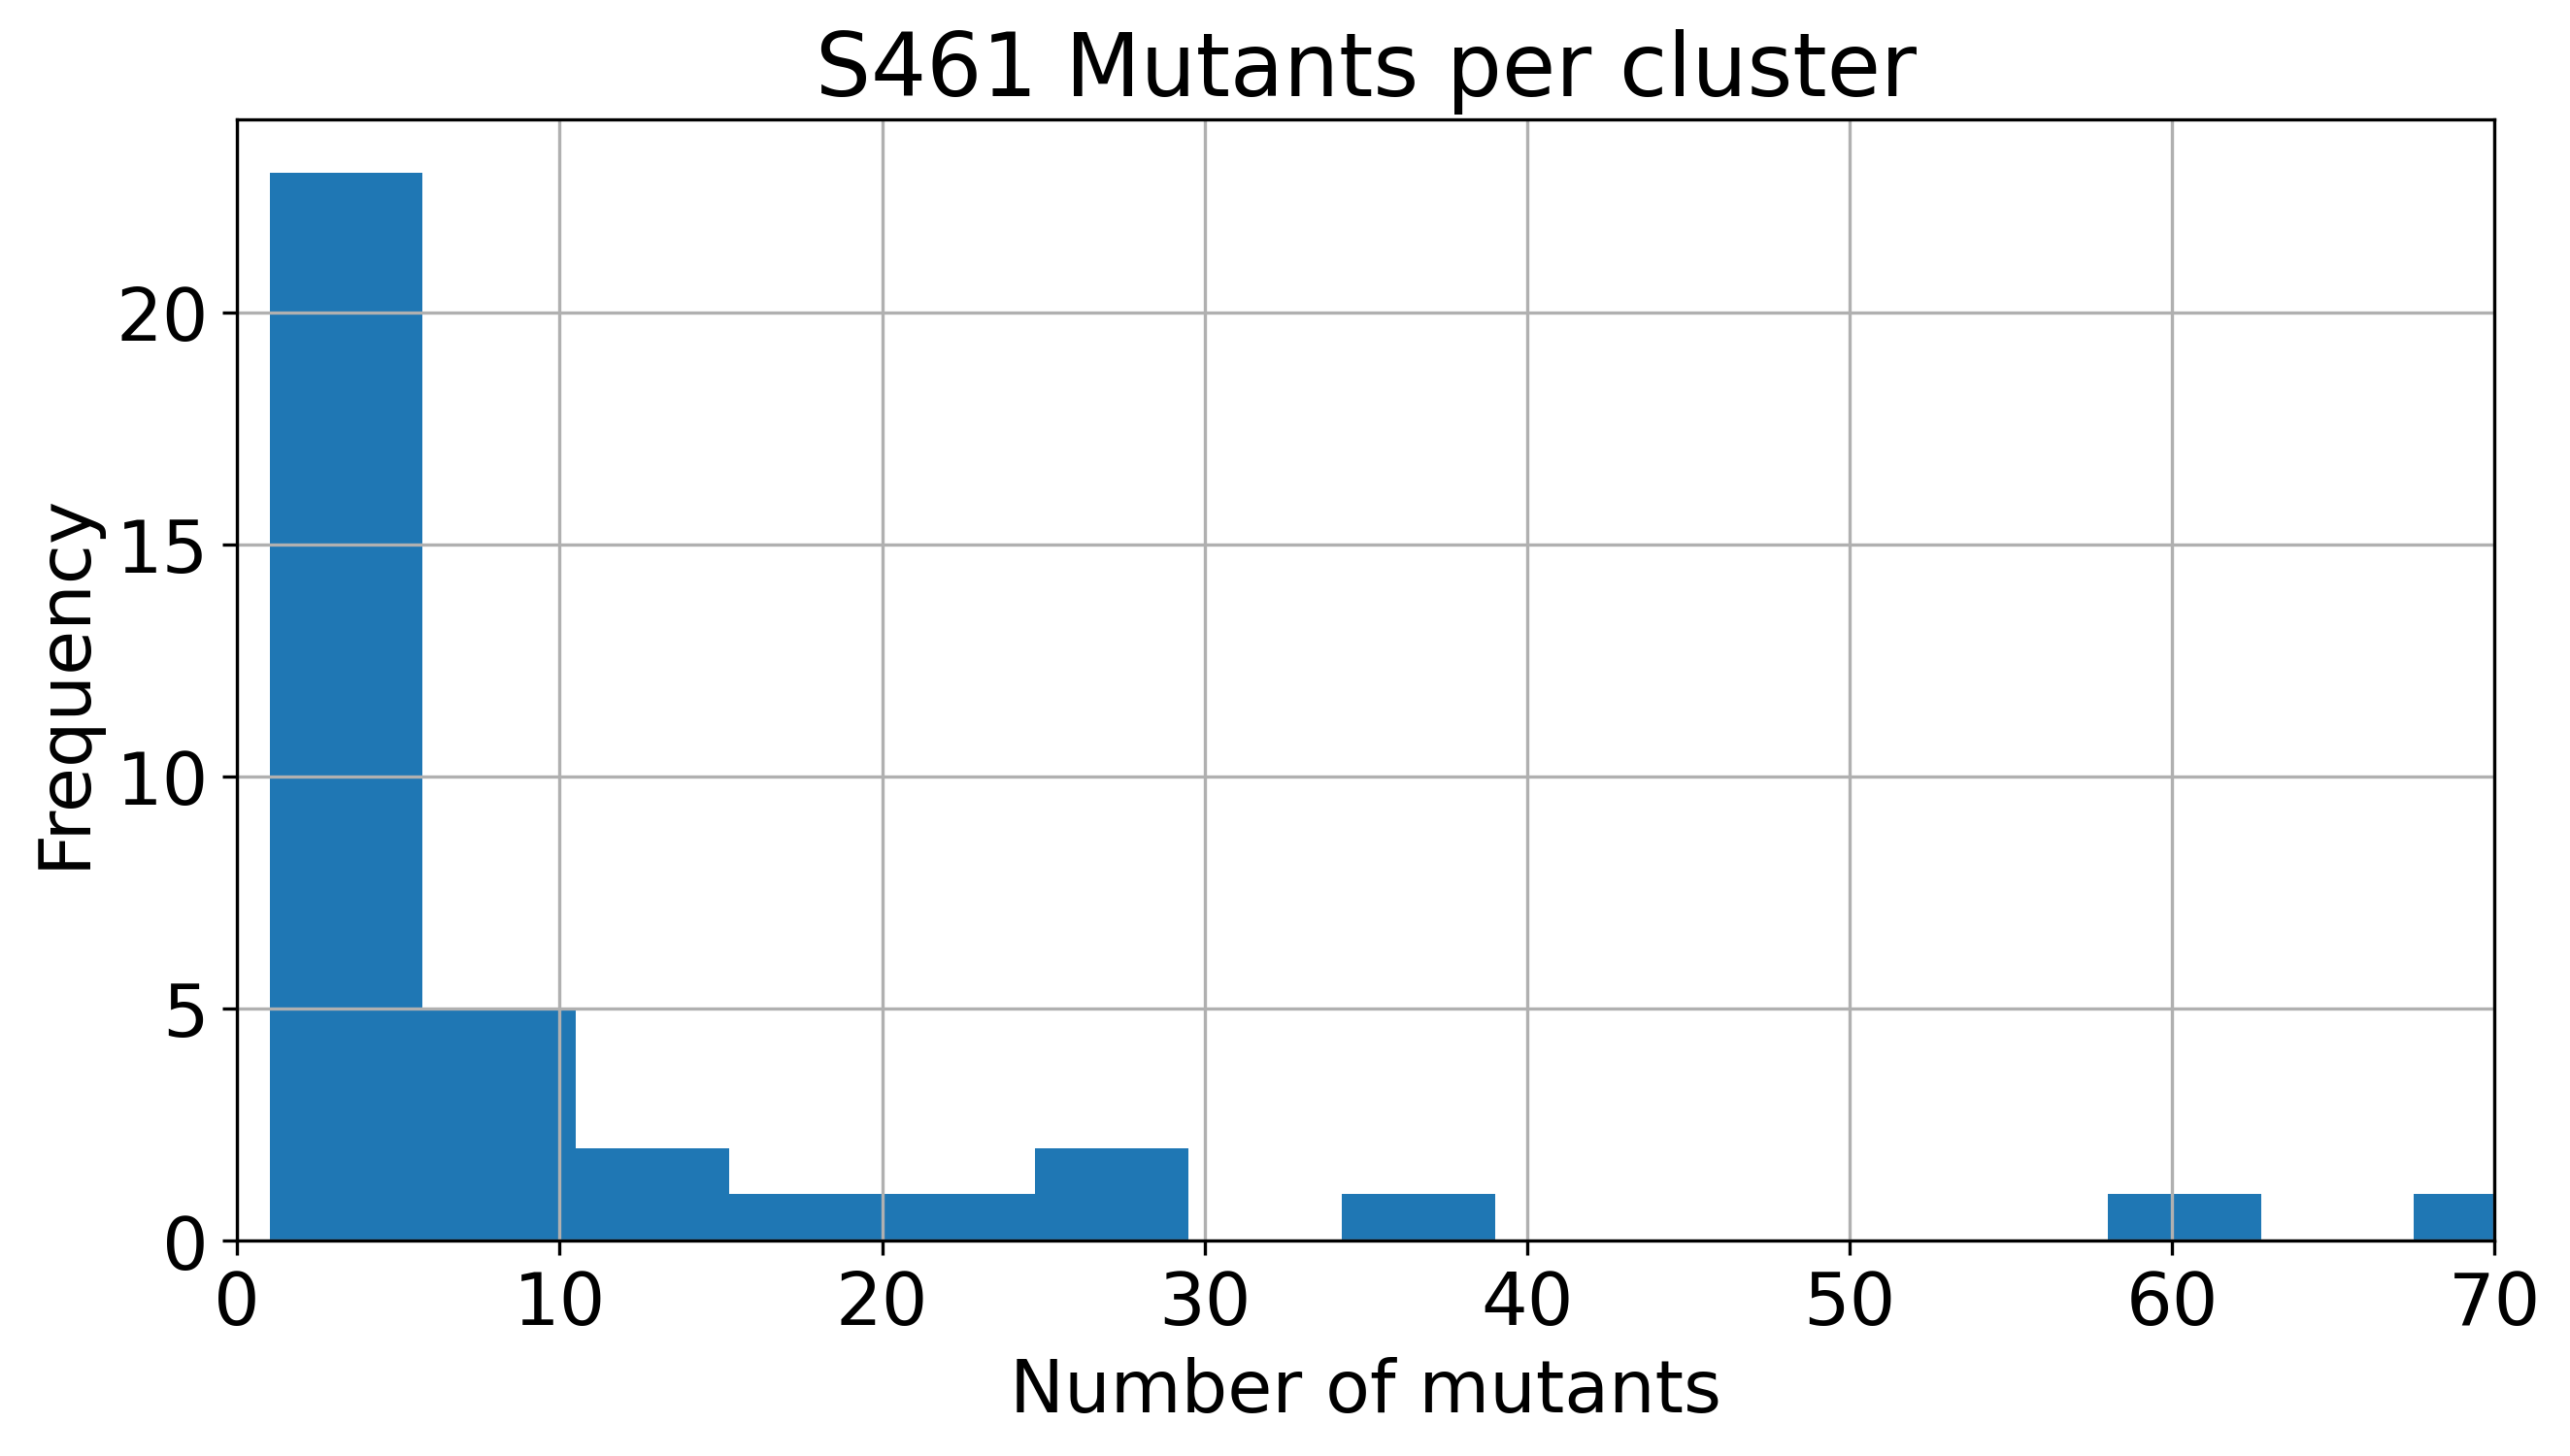

In [2]:
db_class = db

print('Original unique mutations:', len(db_class))

evolutionary = ['tranception', 'msa_transformer', 'esm1v', 'msa', 'esm2', 'ankh']
structural = ['mpnn', 'mif', 'mifst', 'esmif', 'mutcomputex']
supervised = ['MAESTRO', 'ThermoNet', 'INPS', 'PremPS', 'mCSM', 'DUET', 'ACDC', 'I-Mutant3.0', 'SAAFEC', 'MuPro', 'q3421']
untrained = ['DDGun']
potential = ['KORPM', 'PopMusic', 'SDM']
biophysical = ['cartesian_ddg', 'FoldX', 'Evo', 'Cartddg']
transfer = ['stability-oracle']

original_pred_cols = db_class.columns[db_class.columns.str.contains('|'.join(evolutionary + structural + supervised + untrained + potential + biophysical + transfer))]
original_pred_cols = list(original_pred_cols.drop(['msa_file', 'tranception_dms']))
original_pred_cols = [c for c in original_pred_cols if not 'runtime' in c]
original_pred_cols = [c for c in original_pred_cols if not 'cluster' in c]
original_pred_cols = [c for c in original_pred_cols if not 'overlaps' in c]
original_pred_cols = [c for c in original_pred_cols if not 'pll' in c]

db_ddg = db[['ddG_dir']]
db_runtimes = db[[c for c in db.columns if 'runtime' in c]]

original_pred_cols_reduced = deepcopy(original_pred_cols)
for col in [f'esm1v_{i}_dir' for i in range(1,6)]:
    original_pred_cols_reduced.remove(col)
for col in [f'msa_{i}_dir' for i in range(1,6)]:
    original_pred_cols_reduced.remove(col)

original_pred_cols_reduced = [c for c in original_pred_cols_reduced if not 'q3421' in c]

print(original_pred_cols_reduced)

db_class = db_class[original_pred_cols + ['ddG_dir', 'cluster']]

db_class_rescaled = db_class.copy(deep=True)
db_class_rescaled[original_pred_cols] /= db_class_rescaled[original_pred_cols].std()

db_class['mpnn_rosetta_dir'] = db_class['cartesian_ddg_dir'] + db_class['mpnn_20_00_dir']
db_class['random_dir'] = np.random.normal(loc=0, size=len(db_class))
#db_class['korpm_dir'] = db_class['KORPMD_dir']
db_class['ddG'] = db_class['ddG_dir']

db_class = db_class.drop([c+'_dir' for c in ['ACDCNND', 'FoldXD', 'DDGunD', 'CartddgD']], axis=1) #'PopMsD', 'TNetD'

print(f'Detected {len(db_class.loc[db["on_interface_dir"].astype(bool)])} interface mutations')

fig, axes = plt.subplots(1, figsize=(10, 5), dpi=300) 
db_class.groupby('cluster').count().iloc[:, 0].hist(bins=20, ax=axes)
#db_class.groupby('cluster').count().iloc[:, 0].hist(bins=800, ax=axes[1])
plt.xlim([0,70])
plt.title('S461 Mutants per cluster')
plt.xlabel('Number of mutants')
plt.ylabel('Frequency')

db_class

In [3]:
print((db_class.groupby('cluster').count().iloc[:, 0] >= 10).sum(), (db_class.groupby('cluster').count().iloc[:, 0] < 10).sum())

10 28


In [4]:
summ_ = analysis_utils.compute_stats(db_class.reset_index('uid2', drop=True), 
                                    stats=(), 
                                    measurements=['ddG'], grouper='cluster', n_classes=2, n_bootstraps=0, quiet=True)
summ_.to_csv('../data/extended/s461_extended.csv')

In [5]:
summ = analysis_utils.compute_stats(db_class.reset_index('uid2', drop=True), 
                                    stats=('n', 'MCC', 'pred_positives', 'tp', 'auprc', 'spearman', 'ndcg', 'mean_t1s', 'mean_stabilization', 'net_stabilization', 'sensitivity', 'recall@k0.0', 'recall@k1.0', 'mean_reciprocal_rank'), 
                                    measurements=['ddG'], grouper='cluster', n_classes=2, n_bootstraps=100, quiet=True)
tmp1 = summ.reset_index()
tmp1.to_csv('../data/extended/s461_extended_bootstrapped.csv')

In [6]:
remap_names = analysis_utils.remap_names
remap_names_2 = analysis_utils.remap_names_2

remap_cols = {'auprc': 'AUPRC', 'spearman': 'Spearman\'s ρ', 'auppc': 'mean PPC', 'aumsc': 'mean MSC', 'weighted_ndcg': 'wNDCG', 'ndcg': 'NDCG', 
    'weighted_spearman': 'wρ', 'weighted_auprc': 'wAUPRC', 'tp': 'True Positives', 'sensitivity': 'Sensitivity', 'mean_stabilization': 'Mean Stabilization',
    'net_stabilization': 'Net Stabilization', 'accuracy': 'Accuracy', 'mean_reciprocal_rank': 'MRR', 'n': 'n', 'MCC': 'MCC', 'recall@k1.0': 'Recall @ k'}

new_remap_cols = {}
for key, value in remap_cols.items():
    new_remap_cols[key + '_mean'] = value + ' mean'
    new_remap_cols[key + '_std'] = value + ' stdev'

s2 = summ.sort_values('net_stabilization_mean', ascending=False).dropna(how='all', axis=1).reset_index()
s3 = s2.loc[s2['model'].isin(original_pred_cols_reduced + [
            'random_dir', 
            'ddG_dir', 
            'q3421_pslm_rfa_2_dir', 
            'q3421_pslm_rfa_3_dir', 
            'q3421_pslm_rfa_4_dir',
            'q3421_pslm_rfa_5_dir',
            'mpnn_rosetta_dir'])
            ].drop('measurement', axis=1)

s4 = s3[['model_type', 'model',
    'recall@k1.0_mean', 'recall@k1.0_std',
    'ndcg_mean', 'ndcg_std', 
    'spearman_mean', 'spearman_std',
    'auprc_mean', 'auprc_std', 
    'MCC_mean', 'MCC_std', 
    'net_stabilization_mean', 'net_stabilization_std',
    ]]
s4['model'] = s4['model'].map(lambda x: remap_names_2.get(x, x[:-4]))
s5 = s4.set_index(['model_type', 'model'])
s5.columns = [new_remap_cols[c] for c in s5.columns]
s5
# Iterate over the DataFrame and update the mean columns
for column in s5.columns:
    if 'mean' in column:
        stdev_column = column.replace('mean', 'stdev')
        s5[column] = s5[column].round(3).astype(str) + ' ± ' + s5[stdev_column].round(2).astype(str)

# Drop the standard deviation columns
s5 = s5[[col for col in s5.columns if 'stdev' not in col]]
s5.columns = [col[:-5] for col in s5.columns]
s6 = s5.reset_index().rename({'model_type': 'Model Type', 'model': 'Model'}, axis=1)
s6

,Model Type,Model,Recall @ k,NDCG,Spearman's ρ,AUPRC,MCC,Net Stabilization
0,unknown,ΔΔG label,1.0 ± 0.0,1.0 ± 0.0,1.0 ± 0.0,1.0 ± 0.0,1.0 ± 0.0,77.732 ± 34.0
1,evolutionary,ESM-2 15B,0.261 ± 0.15,0.658 ± 0.09,0.314 ± 0.1,0.348 ± 0.06,0.24 ± 0.07,9.557 ± 30.3
2,structural,Rosetta/ProtMPNN,0.26 ± 0.13,0.752 ± 0.1,0.622 ± 0.08,0.484 ± 0.05,0.366 ± 0.07,8.714 ± 29.26
3,evolutionary,Tranception,0.112 ± 0.09,0.524 ± 0.09,0.246 ± 0.1,0.259 ± 0.06,0.19 ± 0.07,3.366 ± 9.41
4,evolutionary,MSA-T median,0.194 ± 0.12,0.592 ± 0.1,0.202 ± 0.08,0.27 ± 0.05,0.144 ± 0.05,-3.521 ± 11.5
5,evolutionary,ESM-2 650M,0.275 ± 0.13,0.626 ± 0.09,0.429 ± 0.1,0.339 ± 0.04,0.234 ± 0.05,-8.262 ± 30.04
6,biophysical,Rosetta CartDDG,0.191 ± 0.11,0.729 ± 0.1,0.594 ± 0.1,0.457 ± 0.05,0.335 ± 0.05,-9.456 ± 29.32
7,evolutionary,MSA-T mean,0.194 ± 0.12,0.585 ± 0.09,0.209 ± 0.08,0.273 ± 0.05,0.136 ± 0.05,-11.196 ± 15.45
8,evolutionary,ESM-1V median,0.299 ± 0.17,0.658 ± 0.11,0.41 ± 0.1,0.397 ± 0.05,0.312 ± 0.03,-12.117 ± 31.22
9,evolutionary,ESM-1V mean,0.299 ± 0.17,0.639 ± 0.1,0.417 ± 0.1,0.401 ± 0.05,0.301 ± 0.03,-13.081 ± 32.2


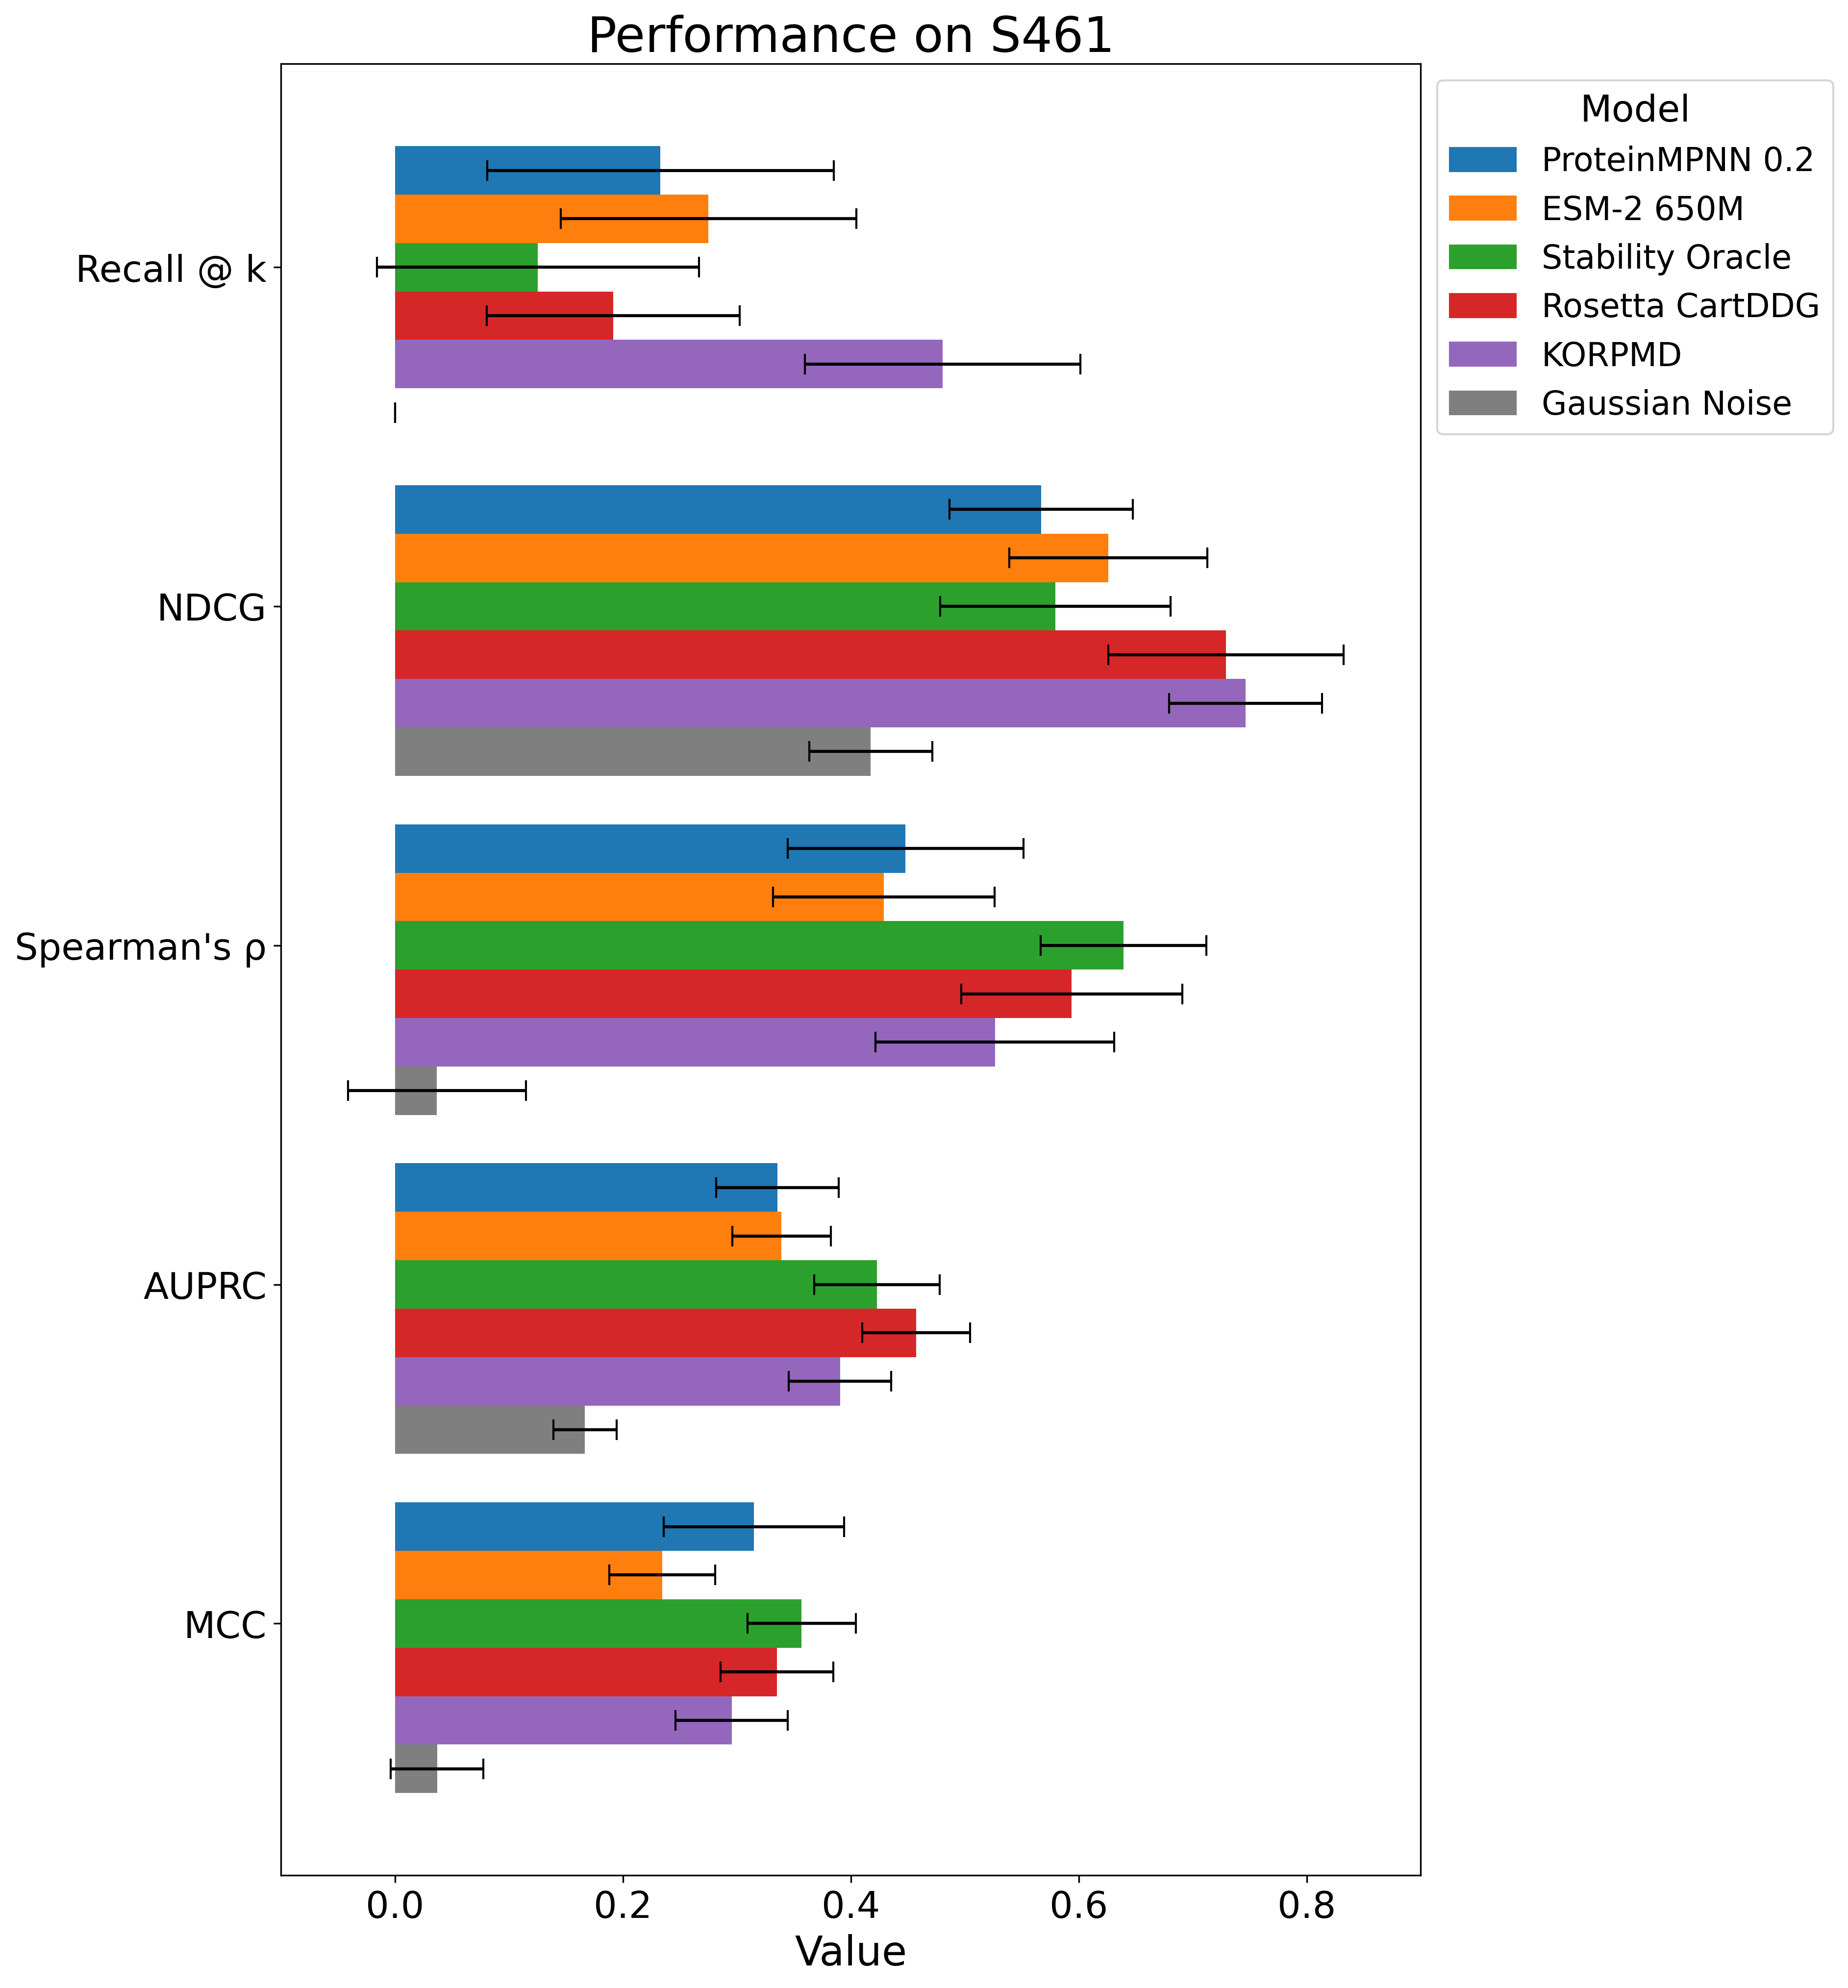

In [7]:
import importlib
importlib.reload(analysis_utils)

remap_names = analysis_utils.remap_names
remap_names_2 = analysis_utils.remap_names_2

tmp3 = tmp1.copy(deep=True)#.set_index('model')
#tmp3['fractional_gain_mean'] = tmp3['net_stabilization_mean'] / tmp3.at['ddG_dir', 'net_stabilization_mean']
#tmp3['fractional_gain_std'] = tmp3['net_stabilization_std'] / tmp3.at['ddG_dir', 'net_stabilization_mean']
#tmp3 = tmp3.reset_index()
#tmp3['fractional_gain_mean']

remap_cols = {'auprc': 'AUPRC', 'spearman': 'Spearman\'s ρ', 'auppc': 'mean PPC', 'aumsc': 'mean MSC', 'weighted_ndcg': 'wNDCG', 'ndcg': 'NDCG',
    'weighted_spearman': 'wρ', 'weighted_auprc': 'wAUPRC', 'tp': 'True Positives', 'sensitivity': 'Sensitivity', 'mean_stabilization': 'Mean Stabilization',
    'net_stabilization': 'Net Stabilization', 'accuracy': 'Accuracy', 'mean_reciprocal_rank': 'MRR', 'n': 'n', 'MCC': 'MCC', 'recall@k1.0': 'Recall @ k'}

new_remap_cols = {}
for key, value in remap_cols.items():
    new_remap_cols[key + '_mean'] = value + ' mean'
    new_remap_cols[key + '_std'] = value + ' stdev'

s2 = tmp3.sort_values('spearman_mean', ascending=False).dropna(how='all', axis=1).reset_index()
s4 = s2.loc[s2['model'].isin(original_pred_cols_reduced + ['random_dir', 'ddG_dir', 'mpnn_rosetta_dir'])]
#s4 = s3[['model', 'n_mean', 'MCC_mean', 'MCC_std', 'auprc_mean', 'auprc_std', 'spearman_mean', 'spearman_std', 'weighted_ndcg_mean', 'weighted_ndcg_std', 'recall@k1.0_mean', 'recall@k1.0_std', 'mean_stabilization_mean', 'mean_stabilization_std']]
#s4['model'] = s4['model'].map(lambda x: remap_names_2.get(x, x[:-4]))
s5 = s4

tmp2 = s5[[ 'model',  
            'MCC_mean', 'MCC_std',
            'auprc_mean', 'auprc_std',
            #'weighted_spearman_mean', 'weighted_spearman_std',
            'spearman_mean', 'spearman_std',
            #'weighted_ndcg_mean', 'weighted_ndcg_std',
            'ndcg_mean', 'ndcg_std',
            'recall@k1.0_mean', 'recall@k1.0_std', 
            ]].set_index('model')

tmp2.columns = [new_remap_cols[c] for c in tmp2.columns]
tmp2 = tmp2.reset_index().drop_duplicates()

#analysis_utils.make_bar_chart(tmp2, models=['ProteinMPNN 0.2', 'ESM-2 650M', 'Stability Oracle', 'Rosetta CartDDG', 'KORPM', 'DDGun3D', 'MAESTRO', 'Gaussian Noise'], title='Q3421', xlim=(-0.5, 0.8), figsize=(24, 16))
analysis_utils.make_bar_chart(tmp2, models=['mpnn_20_00', 'esm2_650M', 'stability-oracle', 'cartesian_ddg', 'KORPMD', 'random'], title='S461', xlim=(-0.1, 0.9), figsize=(10, 16))

In [8]:
tmp2

,model,MCC mean,MCC stdev,AUPRC mean,AUPRC stdev,Spearman's ρ mean,Spearman's ρ stdev,NDCG mean,NDCG stdev,Recall @ k mean,Recall @ k stdev
0,ddG,1.000000,0.000000,1.000000,8.856516e-17,1.000000,9.335587e-17,1.000000,2.060487e-16,1.000000,0.000000
1,stability-oracle,0.356657,0.047530,0.422861,5.516359e-02,0.639024,7.269696e-02,0.579472,1.012455e-01,0.125313,0.141317
2,mpnn_rosetta,0.365579,0.069270,0.484455,5.434273e-02,0.621659,8.011487e-02,0.752348,1.031394e-01,0.259917,0.131003
3,cartesian_ddg,0.335252,0.049393,0.457330,4.713978e-02,0.593738,9.702970e-02,0.729179,1.031133e-01,0.191484,0.111141
4,PopMusic,0.267814,0.039665,0.370364,3.948899e-02,0.581434,7.765275e-02,0.526762,6.044798e-02,0.082536,0.083270
5,MAESTRO,0.311305,0.045777,0.349665,5.362089e-02,0.578428,8.595026e-02,0.514254,6.054463e-02,0.000000,0.000000
6,PremPS,0.176105,0.113177,0.334932,5.846209e-02,0.573186,9.248820e-02,0.697763,1.229750e-01,0.218226,0.120170
7,INPS3D,0.204623,0.060429,0.346108,7.140864e-02,0.569849,9.503634e-02,0.528324,9.914835e-02,0.087917,0.075905
8,DDGun3D,0.305588,0.076659,0.364013,6.495000e-02,0.540784,1.270401e-01,0.713335,1.165981e-01,0.198079,0.124966
9,DUET,0.243682,0.057470,0.322526,3.982127e-02,0.538991,9.757160e-02,0.522621,5.851800e-02,0.079425,0.118549


In [9]:
zs_feats = ['delta_kdh', 'delta_vol', 'rel_ASA']

db_ens = db_class.copy(deep=True).reset_index().set_index('uid2').reset_index(drop=True).set_index('uid')#.join(db_feats_2.drop(['SOL_ACC_dir', 'SOL_ACC_inv'], axis=1))
#db_ens = db_ens.rename({'ddG_dir': 'ddG'}, axis=1) 
#models = original_pred_cols_reduced + [c + '_dir' for c in zs_feats]
models = list(db_class.columns) #+ [z+'_dir' for z in zs_feats]
models.remove('ddG_dir')
models = [c for c in models if not 'q3421' in c]
#models.remove('ddG_dir')

#for zs in zs_feats:
#    db_ens[zs+'_dir'] = db_ens[zs]

print(len(db_ens))
db_ens['random_dir'] = np.random.normal(size=len(db_ens)) - 0.5
#db_ens['random_inv'] = np.random.normal(size=len(db_ens)) - 0.5
#db_ens = db_ens.drop(['KORPMD_dir', 'CartddgD_dir', 'FoldXD_dir', 'EvoD_dir', 'Dyna2D_dir', 'PopMsD_dir', 'DDGunD_dir', 'TNetD_dir', 'ACDCNND_dir'], axis=1)
dfm = db_ens.copy(deep=True)
models

461


['KORPMD_dir',
 'EvoD_dir',
 'ACDC-NN-Seq_dir',
 'ACDC-NN-Seq_inv',
 'ACDC-NN_dir',
 'ACDC-NN_inv',
 'DDGun3D_dir',
 'DDGun3D_inv',
 'DDGun_dir',
 'DDGun_inv',
 'DUET_dir',
 'DUET_inv',
 'FoldX_dir',
 'FoldX_inv',
 'I-Mutant3.0-Seq_dir',
 'I-Mutant3.0-Seq_inv',
 'I-Mutant3.0_dir',
 'I-Mutant3.0_inv',
 'INPS-Seq_dir',
 'INPS-Seq_inv',
 'INPS3D_dir',
 'INPS3D_inv',
 'MAESTRO_dir',
 'MAESTRO_inv',
 'MuPro_dir',
 'MuPro_inv',
 'PopMusic_dir',
 'PopMusic_inv',
 'PremPS_dir',
 'PremPS_inv',
 'SAAFEC-Seq_dir',
 'SAAFEC-Seq_inv',
 'SDM_dir',
 'SDM_inv',
 'ThermoNet_dir',
 'ThermoNet_inv',
 'esmif_monomer_dir',
 'mCSM_dir',
 'mCSM_inv',
 'mpnn_10_00_dir',
 'mpnn_20_00_dir',
 'mpnn_30_00_dir',
 'esmif_multimer_dir',
 'esm2_3B_dir',
 'esm2_15B_half_dir',
 'msa_1_dir',
 'msa_2_dir',
 'msa_3_dir',
 'msa_4_dir',
 'msa_5_dir',
 'msa_transformer_median_dir',
 'msa_transformer_mean_dir',
 'tranception_dir',
 'esm2_150M_dir',
 'esm2_650M_dir',
 'esm1v_1_dir',
 'esm1v_2_dir',
 'esm1v_3_dir',
 'esm1v_4_di

In [10]:
weights = [1, 0.5, 0.2]
#weights2 = [0.8, 0.3]

all_cols = []

tmp = []
for model1 in models:
    for model2 in models:
        if model1[-4:] == model2[-4:] and model1 != model2: #(model1.split('_')[0] != model2.split('_')[0]) and (model1[:4] != model2[:4]) and
            for weight in weights:
                tmp.append(pd.Series(dfm[model1]/dfm[model1].std() + dfm[model2]/dfm[model2].std() * weight, name=f'{model1} + {model2} * {weight}'))
                all_cols.append(f'{model1} + {model2} * {weight}')
                #for model3 in models:
                #    if model2 != model3 and model1 != model3:
                #        for weight2 in weights2:
                #            tmp.append(pd.Series(dfm[model1] + dfm[model2] * weight + dfm[model3] * weight2, name=f'{model1} + {model2} * {weight} + {model3} * {weight2}'))
                #            all_cols.append(f'{model1} + {model2} * {weight} + {model3} * {weight2}')

dfm = pd.concat([dfm] + tmp, axis=1)
dfm = dfm.join(db_runtimes)
#dfm.to_csv(os.path.join(path, 'results', 'ensemble_s461_2_models_3_weights_preds.csv'))
dfm.columns

Index(['KORPMD_dir', 'EvoD_dir', 'ACDC-NN-Seq_dir', 'ACDC-NN-Seq_inv',
       'ACDC-NN_dir', 'ACDC-NN_inv', 'DDGun3D_dir', 'DDGun3D_inv', 'DDGun_dir',
       'DDGun_inv',
       ...
       'runtime_esm1v_3_dir', 'runtime_esm1v_4_dir', 'runtime_esm1v_5_dir',
       'runtime_esm1v_median_dir', 'runtime_esm1v_mean_dir',
       'runtime_ankh_dir', 'runtime_mif_dir', 'runtime_mifst_dir',
       'runtime_korpm_dir', 'runtime_cartesian_ddg_dir'],
      dtype='object', length=8976)

In [11]:
def get_summary_df(db_complete, cols=None, saveloc=os.path.join(path, 'results', 'ensemble_s461_2_models_3_weights_results.csv'), stats=(), stacked=False):

    assert os.path.exists(os.path.dirname(saveloc))
    assert not os.path.exists(saveloc)
    #if cols is None:
    #    cols = db_complete.columns.drop(['code'])#, 'ddG_dir', 'ddG_inv'])

    #if not stacked:
    #    db_stacked = stack_frames(db_complete)
    #else:
    #    db_stacked = db_complete
    #db_stacked['code'] = list(db_stacked.reset_index()['uid'].str[:4])

    df_summ = analysis_utils.compute_stats(db_complete, stats=(), grouper='cluster', measurements=['ddG']).reset_index().set_index(['measurement', 'model'])#.join(df_reg) #.drop('n_total', axis=1))
    df_summ = df_summ.reset_index().rename({'index': 'model'}, axis=1).set_index(['measurement', 'model_type', 'model', 'class'])
    df_summ = df_summ.sort_index(level=1).sort_index(level=0)#.drop_duplicates()
    df_summ.to_csv(saveloc)
    return df_summ

In [12]:
import importlib
importlib.reload(analysis_utils)
# takes a long time to compute and has already been done
#d1 = get_summary_df(dfm, saveloc=os.path.join(path, 'data', 'pairwise', 'pairwise_s461_combinations_3_weights.csv'), stats=()) 

d1 = pd.read_csv(os.path.join(path, 'data', 'pairwise', 'pairwise_s461_combinations_3_weights.csv')).set_index(['measurement', 'model_type', 'model', 'class'])

['ACDC-NN_dir', 'DDGun3D_dir', 'DUET_dir', 'Dynamut_dir', 'FoldX_dir', 'EvoD_dir', 'I-Mutant3.0_dir', 'INPS3D_dir', 'MAESTRO_dir', 'MUpro_dir', 'PopMusic_dir', 'PremPS_dir', 'ThermoNet_dir', 'SAAFEC-Seq_dir', 'SDM_dir', 'ThermoNet_dir', 'mCSM_dir', 'cartesian_ddg_dir', 'esm1v_mean_dir', 'msa_transformer_mean_dir', 'tranception_dir', 'ankh_dir', 'esm2_dir', 'esmif_multimer_dir', 'mpnn_20_00_dir', 'mif_dir', 'mifst_dir', 'KORPMD_dir', 'mutcomputex_dir', 'stability-oracle_dir']
461
0.12048281269827099
['Rosetta CartDDG', 'PremPS_dir', 'PopMusic_dir', 'MAESTRO_dir', 'INPS3D_dir', 'DDGun3D_dir', 'DUET_dir', 'ACDC-NN_dir', 'KORPMD_dir', 'mCSM_dir', 'SDM_dir', 'ThermoNet_dir', 'SAAFEC-Seq_dir', 'I-Mutant3.0_dir', 'EvoD_dir', 'MIF', 'Ankh', 'ProteinMPNN 0.2', 'ESM-1V mean', 'ESM-IF', 'MIF-ST', 'FoldX_dir', 'Tranception', 'MSA-T mean']


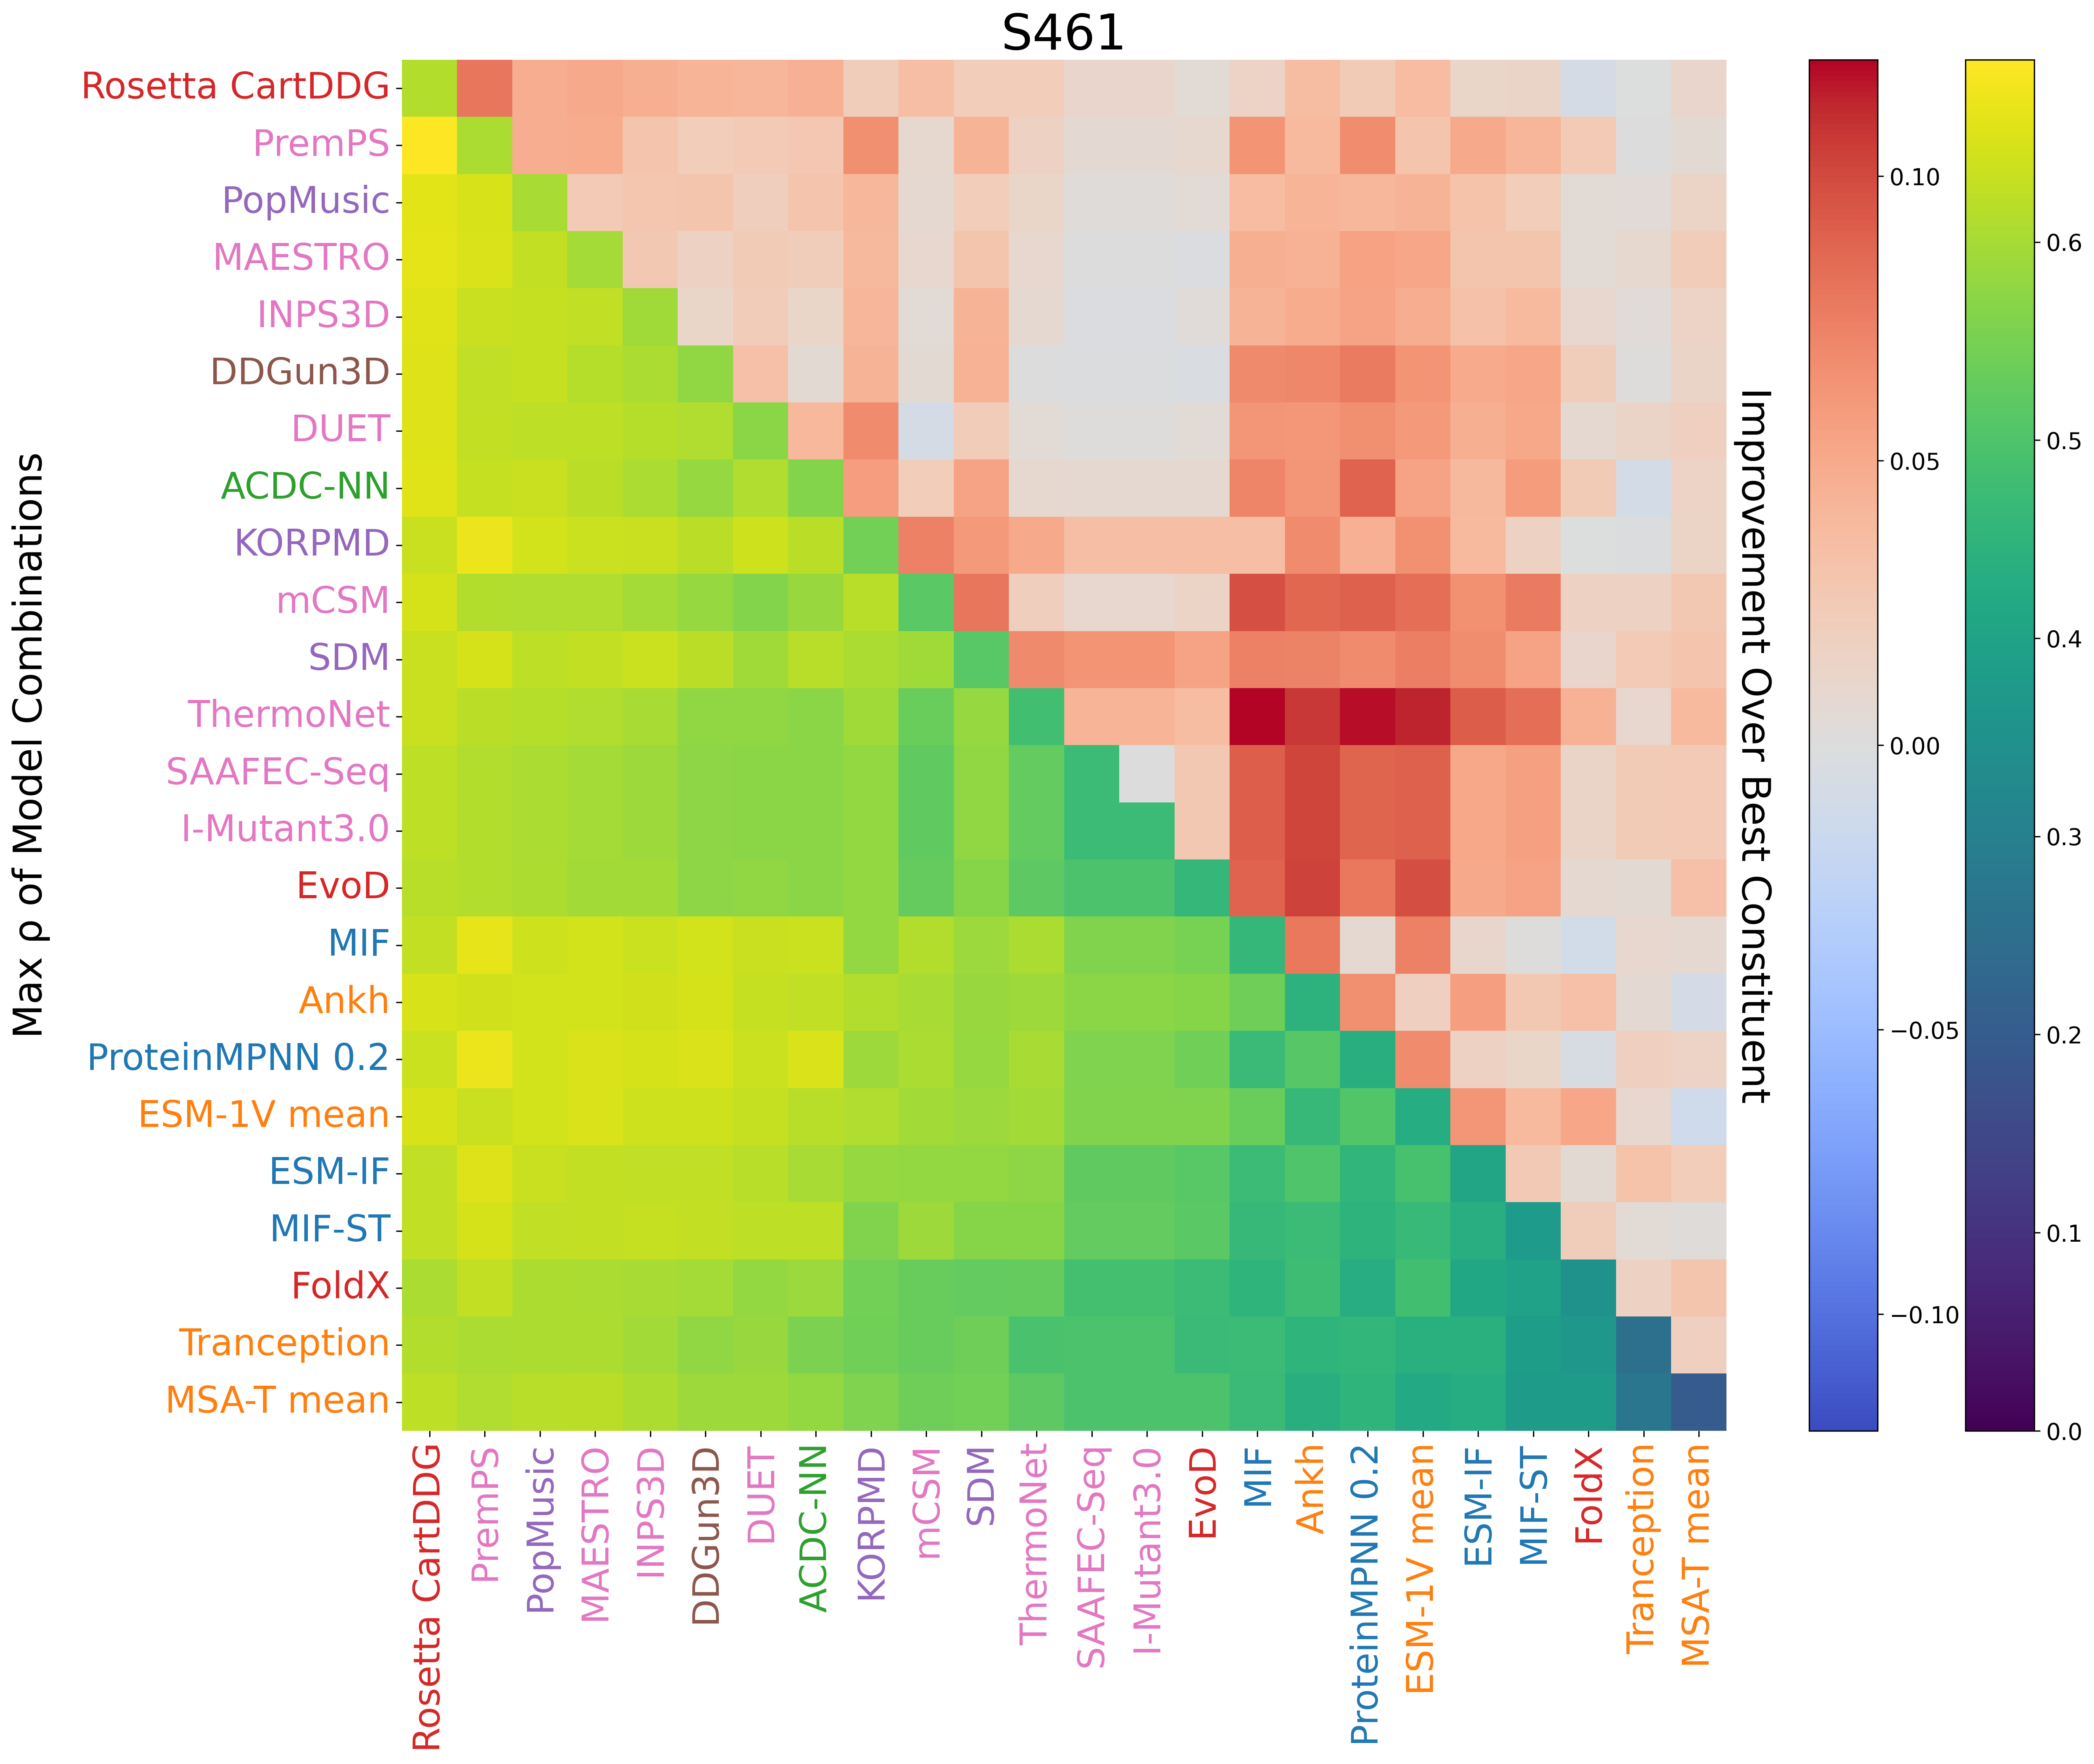

In [13]:
import importlib
importlib.reload(analysis_utils)


subset  = [ 'ACDC-NN_dir', 'DDGun3D_dir', 'DUET_dir', 'Dynamut_dir', 'FoldX_dir',
            'EvoD_dir', 'I-Mutant3.0_dir', 'INPS3D_dir', 'MAESTRO_dir', 'MUpro_dir',
            'PopMusic_dir', 'PremPS_dir', 'ThermoNet_dir', 'SAAFEC-Seq_dir', 'SDM_dir',     
            'ThermoNet_dir', 'mCSM_dir', 'cartesian_ddg_dir', 'esm1v_mean_dir',
            'msa_transformer_mean_dir', 'tranception_dir', 'ankh_dir', 'esm2_dir',
            'esmif_multimer_dir', 'mpnn_20_00_dir', 'mif_dir', 'mifst_dir',
            'KORPMD_dir', 'mutcomputex_dir', 'stability-oracle_dir'
        ]

print(subset)

#custom_colors = dict(zip([key+'_dir' for key in custom_colors.keys()], list(custom_colors.values())))
#print(custom_colors)

measurement = 'ddG'
statistic = 'spearman'

db_ddg_ = db_ddg.copy(deep=True)
db_ddg_ = db_ddg_.rename({'ddG_dir': 'ddG'}, axis=1).reset_index('uid2', drop=True)
d3 = d1.copy(deep=True)

#dfm['code'] = dfm.index.str[:4]

stat_df_, delta_df = analysis_utils.model_combinations_heatmap(d3, dfm.fillna(0), db_ddg_, statistic, measurement, threshold=0, subset=subset, n_bootstraps=0, grouper=None, upper='delta', annot=False, title='S461')
#stat_df = analysis_utils.model_combinations_heatmap_2(d2, dfm, statistic, direction, upper, threshold=None, custom_colors=custom_colors)
stat_df = stat_df_
stat_df = stat_df.drop_duplicates(subset=[f'{statistic}', 'runtime_cpu', 'runtime_gpu']).reset_index(drop=True).sort_values(f'{statistic}', ascending=False).reset_index(drop=True).reset_index()
stat_df['model1'] = stat_df['model1'].map(lambda x: remap_names_2.get(x, x[:-4]))
stat_df['model2'] = stat_df['model2'].map(lambda x: remap_names_2.get(x, x[:-4]))

stat_df = stat_df.rename({'index': 'rank'}, axis=1)
stat_df['rank'] += 1
stat_df = stat_df.set_index('rank')
out = stat_df.head(30)
models_ = set(list(out['model1']) + list(out['model2']))
#stat_df

In [14]:
stat_df_ = stat_df.applymap(lambda x: np.nan if x==-0.0001 else x)
stat_df_ = stat_df.applymap(lambda x: round(x, 2) if type(x)==float else x)
for source, target in remap_names.items():
    stat_df_.loc[stat_df_['model1']==source, 'model1'] = target
    stat_df_.loc[stat_df_['model2']==source, 'model2'] = target
stat_df_ = stat_df_.reset_index().drop('weight1', axis=1).rename({'rank': 'Rank', 'model1': 'Base model', 'model2': 'Added Model', 'weight2': 'Weight', 'corr': 'Model Correlation', 'runtime_cpu': 'CPU time (s)', 'runtime_gpu': 'GPU time (s)', 'spearman': 'Spearman\'s rho'}, axis=1)
#stat_df_.to_csv('../data/stat_df_s461.csv')
stat_df_.head(30)

,Rank,Base model,Added Model,Weight,Spearman's rho,Model Correlation,CPU time (s),GPU time (s)
0,1,PremPS,Rosetta CartDDG,1.0,0.69,0.53,251313.0,-0.00
1,2,PremPS,ProteinMPNN 0.2,0.5,0.67,0.26,-0.0,4.56
2,3,PremPS,KORPMD,0.5,0.67,0.44,-0.0,-0.00
3,4,PremPS,MIF,0.5,0.67,0.30,-0.0,42.32
4,5,MAESTRO,Rosetta CartDDG,1.0,0.66,0.62,251313.0,-0.00
5,6,PopMusic,Rosetta CartDDG,1.0,0.66,0.66,251313.0,-0.00
6,7,INPS3D,Rosetta CartDDG,1.0,0.66,0.63,251313.0,-0.00
7,8,ACDC-NN,Rosetta CartDDG,1.0,0.66,0.61,251313.0,-0.00
8,9,DDGun3D,Rosetta CartDDG,1.0,0.66,0.64,251313.0,-0.00
9,10,PremPS,ESM-IF,0.5,0.65,0.29,-0.0,78.34


461
42.424
['Tranception', 'MSA-T mean', 'ESM-1V mean', 'PremPS_dir', 'Rosetta CartDDG', 'MIF-ST', 'Ankh', 'SAAFEC-Seq_dir', 'I-Mutant3.0_dir', 'INPS3D_dir', 'PopMusic_dir', 'ESM-IF', 'mCSM_dir', 'DUET_dir', 'MIF', 'MAESTRO_dir', 'ProteinMPNN 0.2', 'ACDC-NN_dir', 'DDGun3D_dir', 'KORPMD_dir', 'EvoD_dir', 'SDM_dir', 'ThermoNet_dir', 'FoldX_dir']


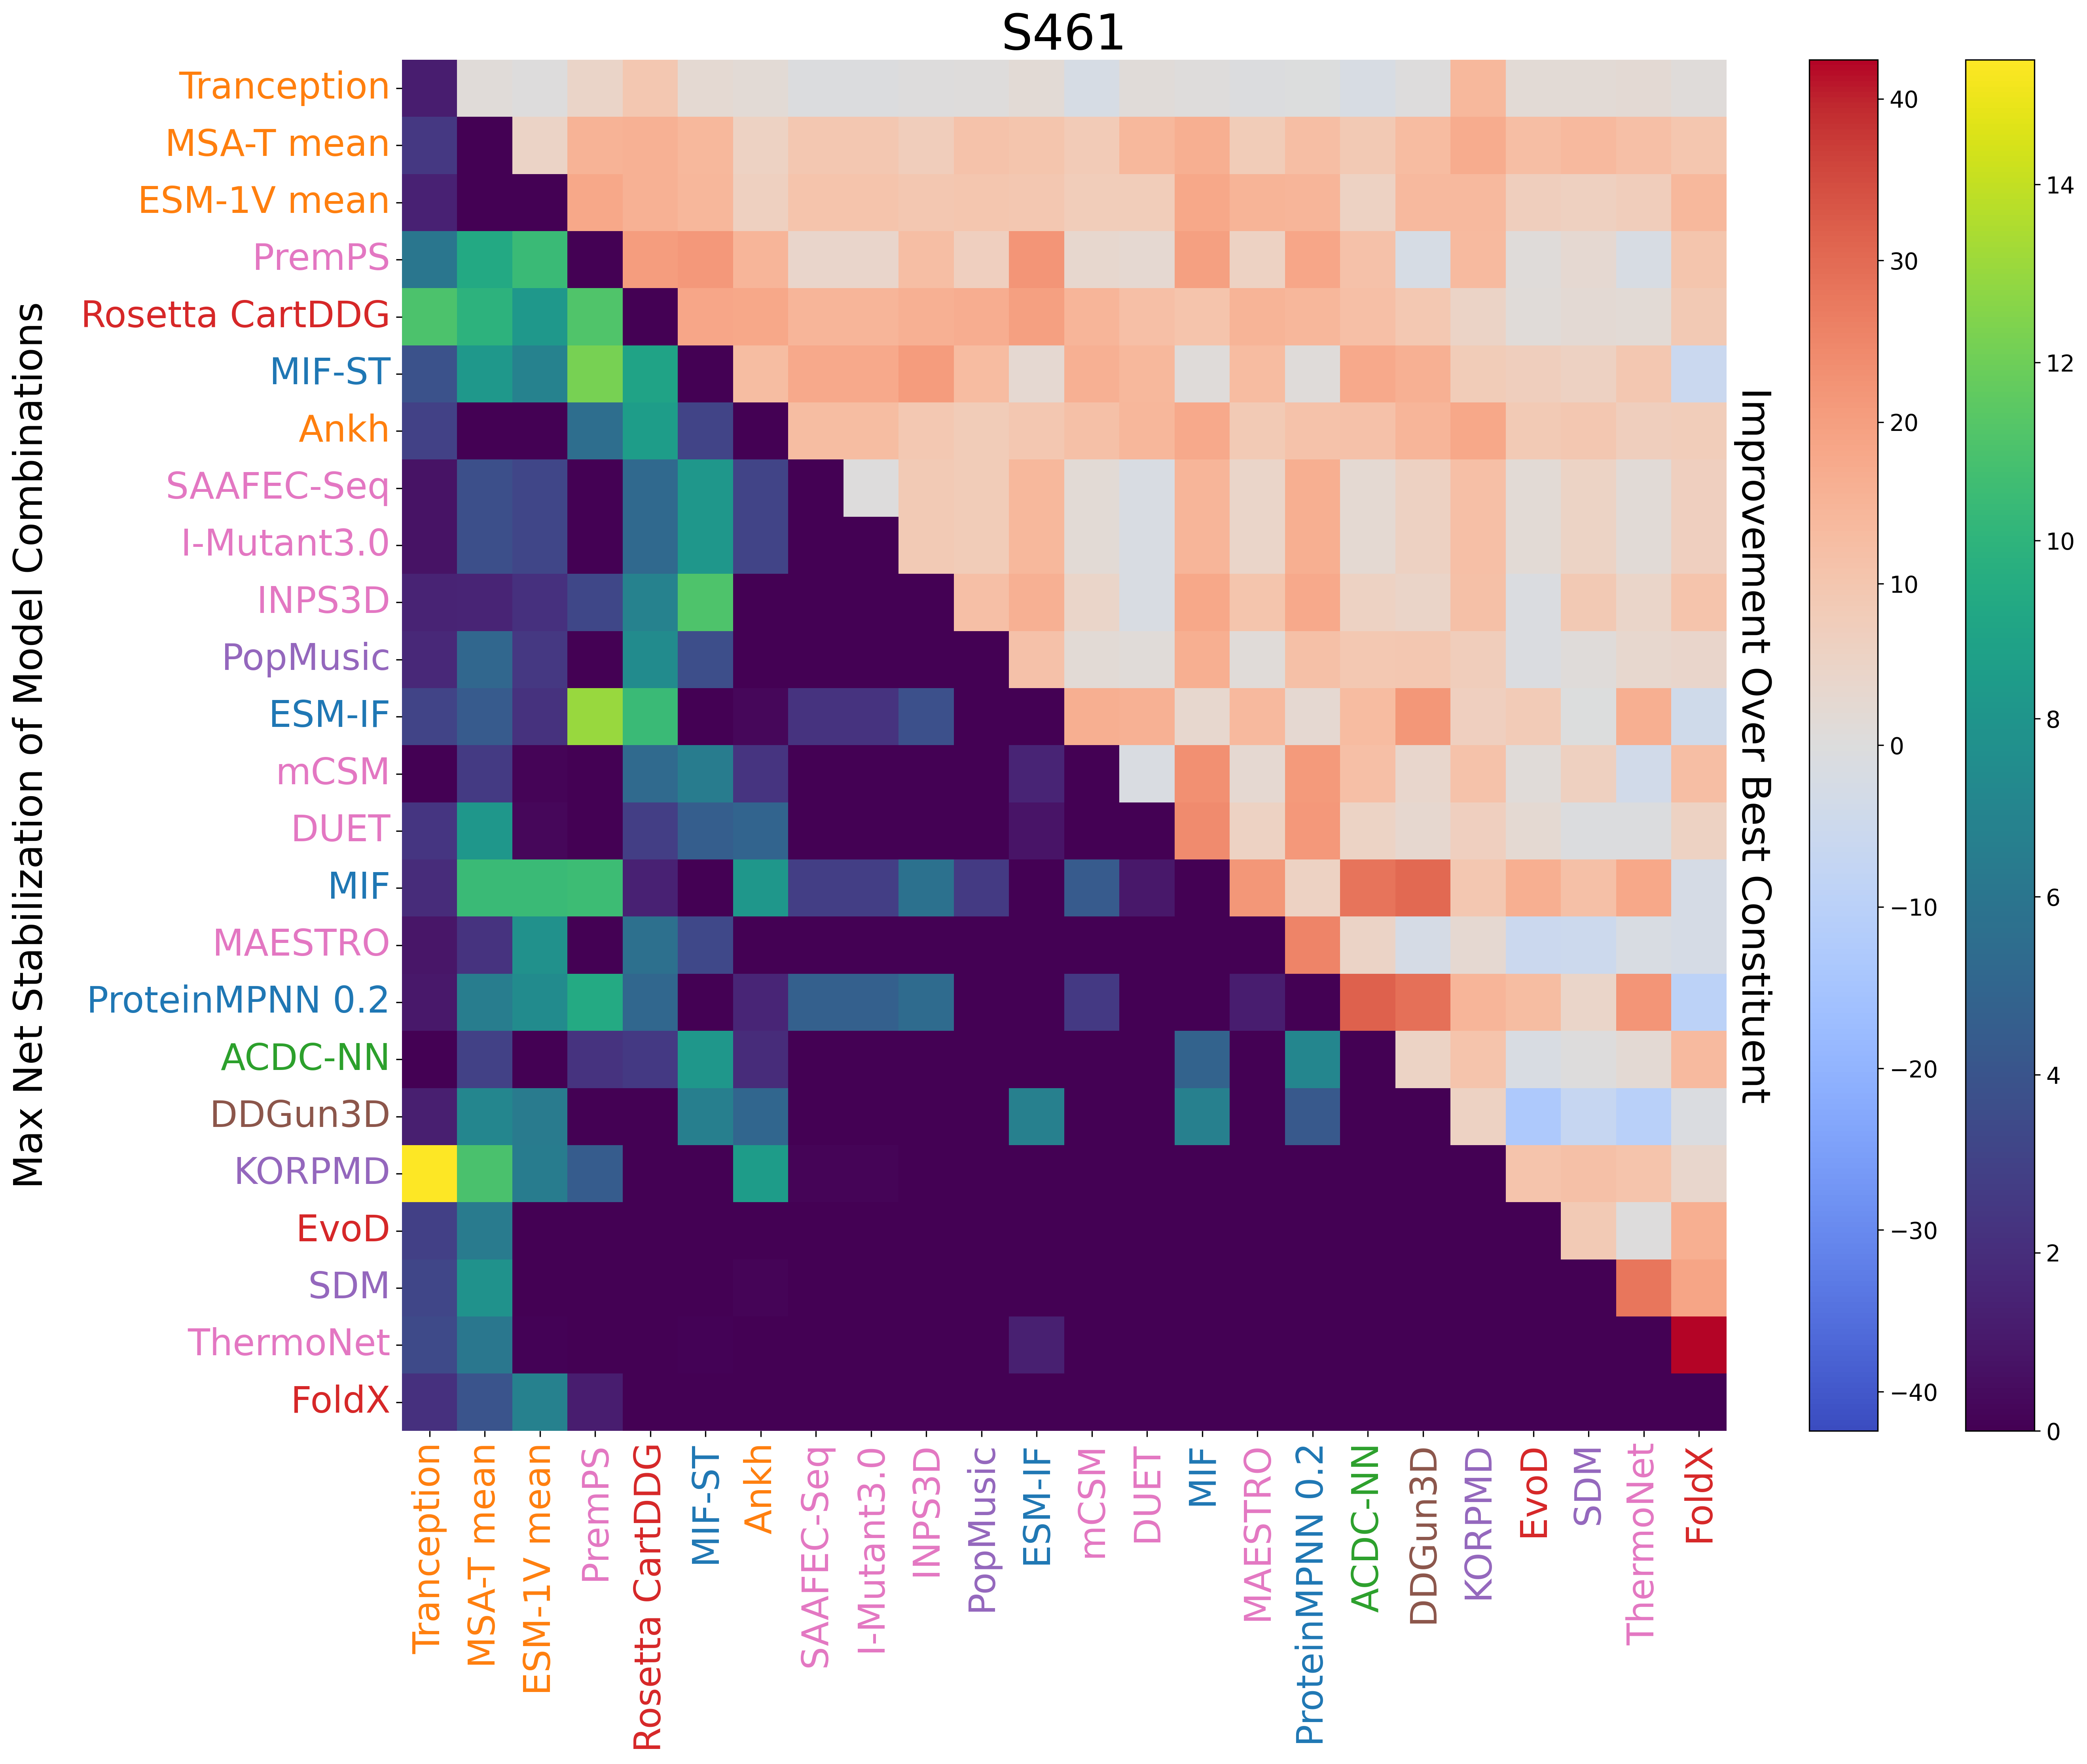

{'ACDC-NN', 'PremPS', 'MIF-ST', 'MAESTRO', 'INPS3D', 'DDGun3D', 'Ankh', 'ProteinMPNN 0.2', 'PopMusic', 'KORPMD', 'MIF', 'SDM', 'I-Mutant3.0', 'ESM-1V mean', 'MSA-T mean', 'Rosetta CartDDG', 'Tranception', 'DUET', 'ESM-IF'}


In [15]:
measurement = 'ddG'
statistic = 'net_stabilization'

db_ddg_ = db_ddg.copy(deep=True)
db_ddg_ = db_ddg_.rename({'ddG_dir': 'ddG'}, axis=1).reset_index('uid2', drop=True)
d3 = d1.copy(deep=True)

#dfm['code'] = dfm.index.str[:4]

stat_df_, delta_df = analysis_utils.model_combinations_heatmap(d3, dfm.fillna(0), db_ddg_, statistic, measurement, threshold=0, subset=subset, n_bootstraps=0, grouper=None, upper='delta', annot=False, title='S461')
#stat_df = analysis_utils.model_combinations_heatmap_2(d2, dfm, statistic, direction, upper, threshold=None, custom_colors=custom_colors)
stat_df = stat_df_
stat_df = stat_df.drop_duplicates(subset=[f'{statistic}', 'runtime_cpu', 'runtime_gpu']).reset_index(drop=True).sort_values(f'{statistic}', ascending=False).reset_index(drop=True).reset_index()
stat_df['model1'] = stat_df['model1'].map(lambda x: remap_names_2.get(x, x[:-4]))
stat_df['model2'] = stat_df['model2'].map(lambda x: remap_names_2.get(x, x[:-4]))

stat_df = stat_df.rename({'index': 'rank'}, axis=1)
stat_df['rank'] += 1
stat_df = stat_df.set_index('rank')
out = stat_df.head(30)
models_ = set(list(out['model1']) + list(out['model2']))
print(models_)
#stat_df

461
0.12990261825319133
['Rosetta CartDDG', 'ESM-1V mean', 'KORPMD_dir', 'MIF', 'DDGun3D_dir', 'PopMusic_dir', 'ACDC-NN_dir', 'MAESTRO_dir', 'SDM_dir', 'ESM-IF', 'MIF-ST', 'PremPS_dir', 'INPS3D_dir', 'ProteinMPNN 0.2', 'Ankh', 'DUET_dir', 'ThermoNet_dir', 'SAAFEC-Seq_dir', 'I-Mutant3.0_dir', 'EvoD_dir', 'mCSM_dir', 'MSA-T mean', 'Tranception', 'FoldX_dir']


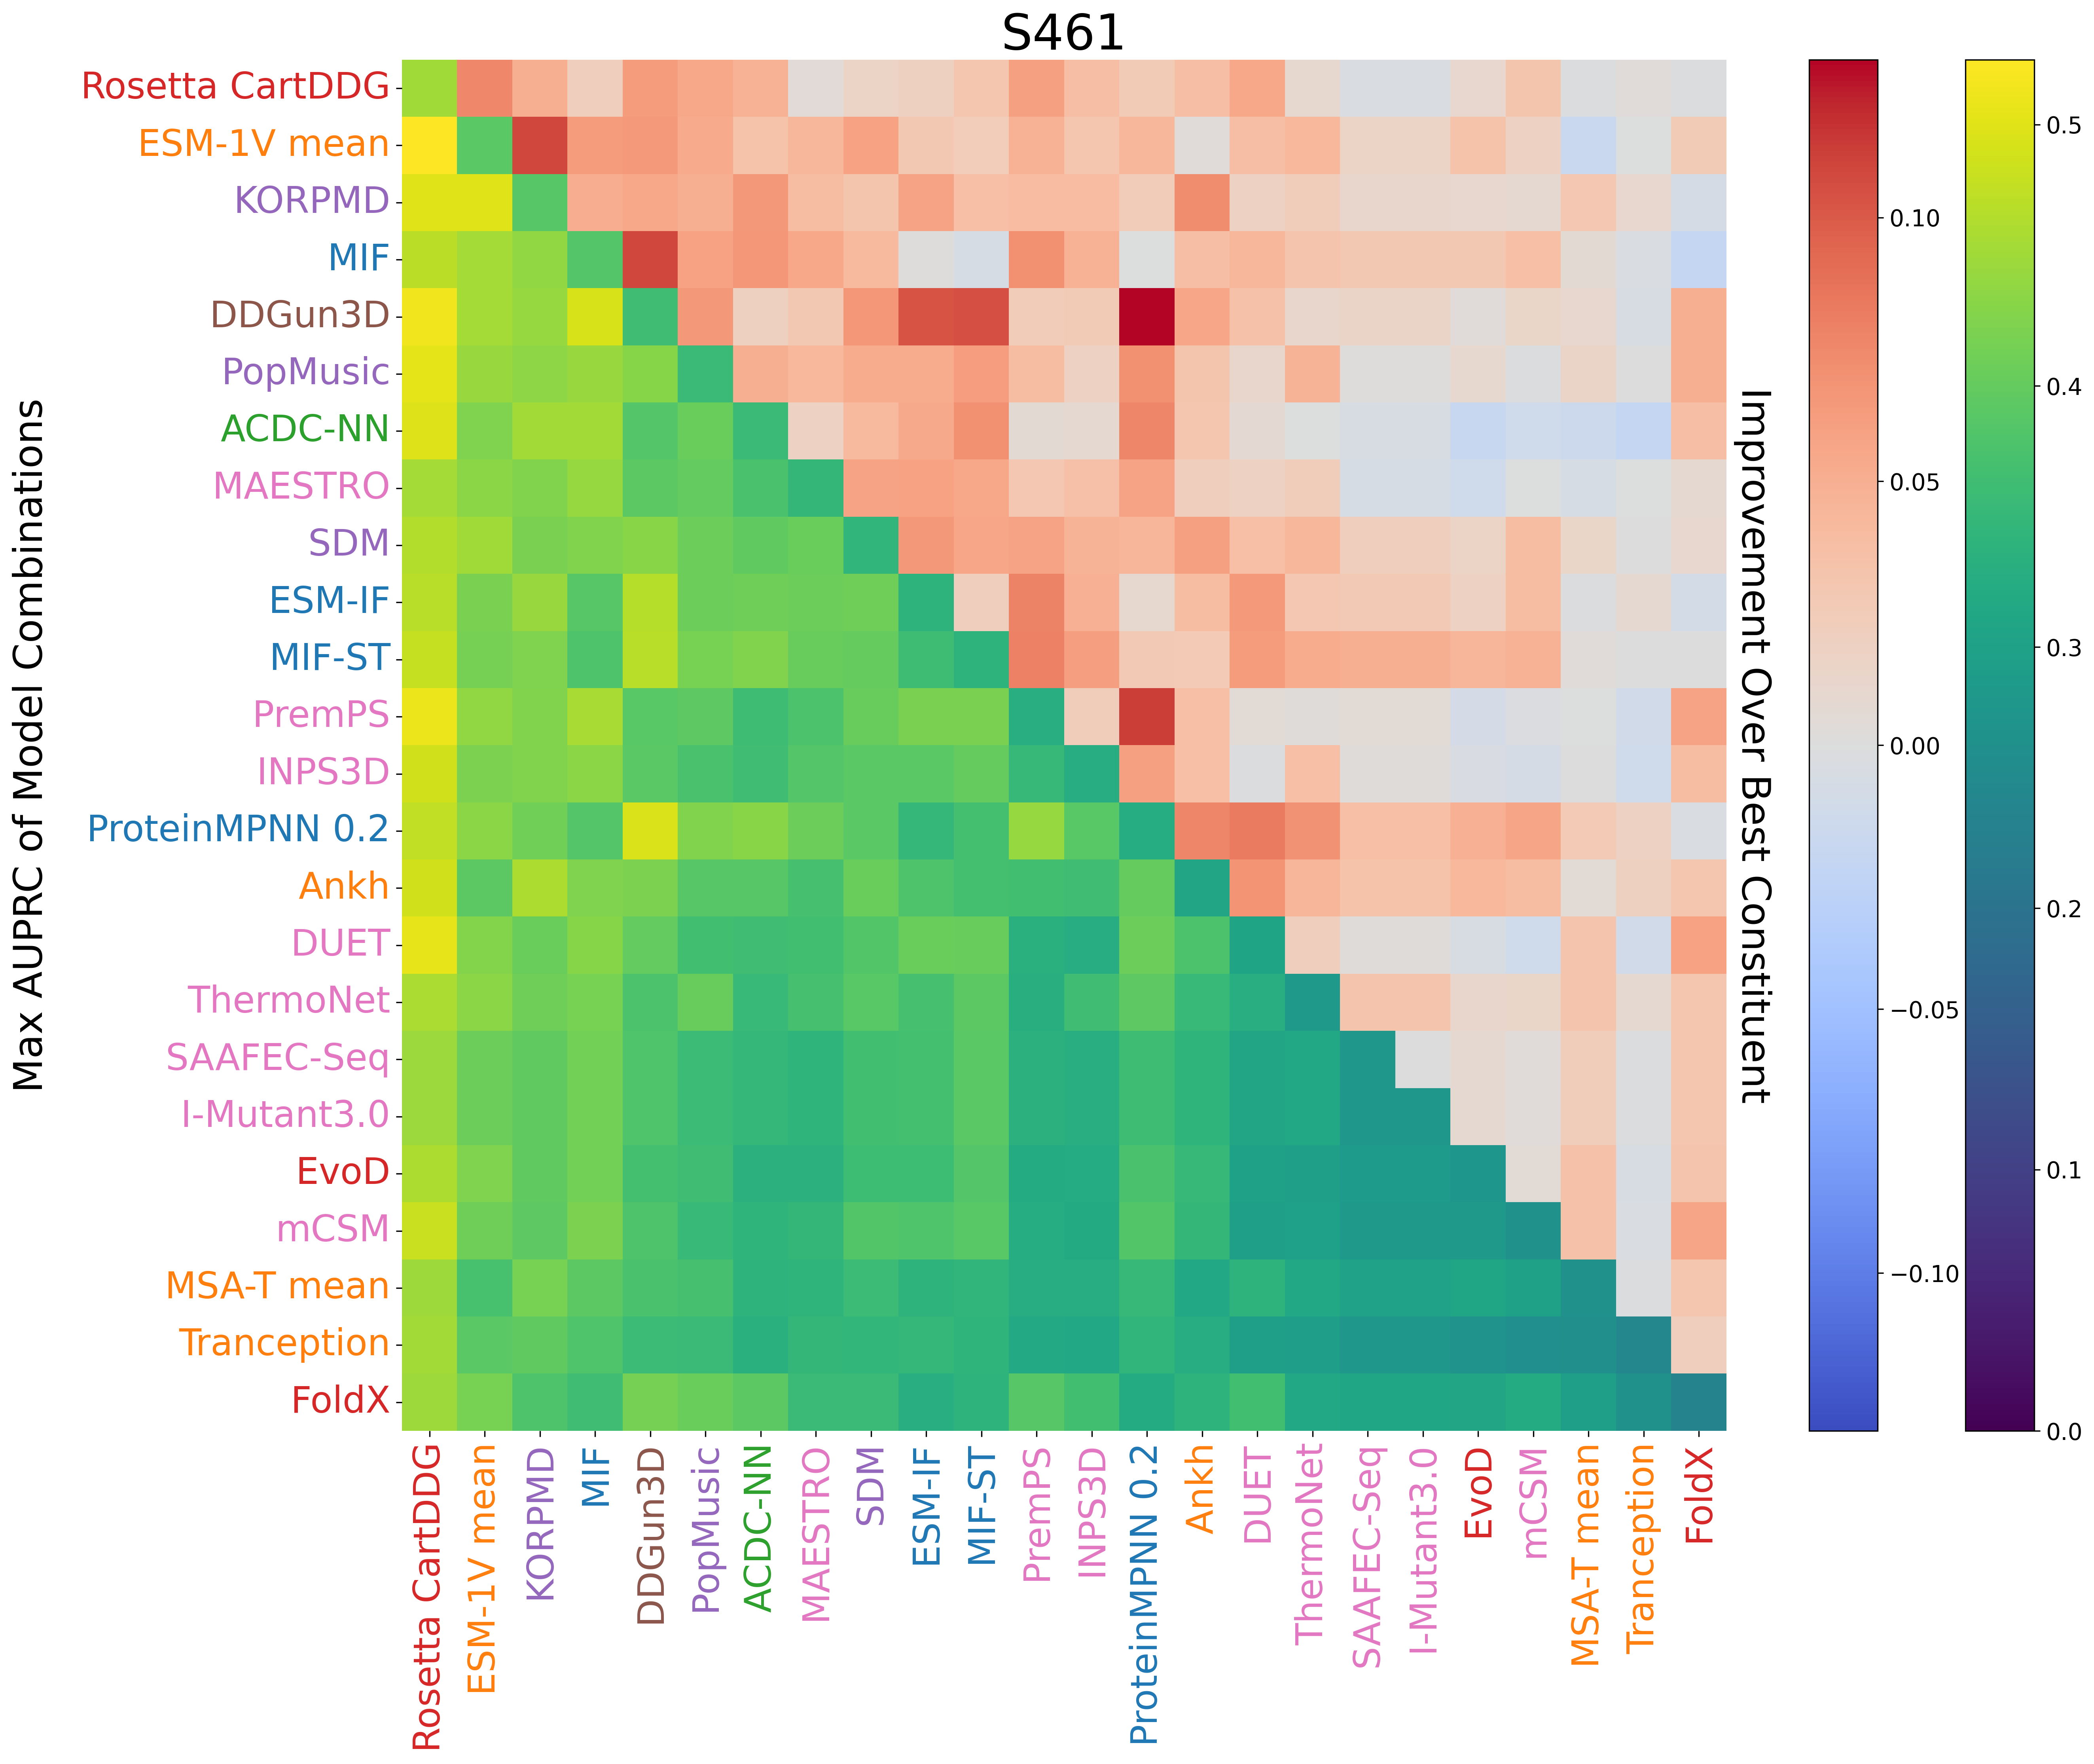

{'ACDC-NN', 'PremPS', 'MIF-ST', 'ThermoNet', 'MAESTRO', 'INPS3D', 'DDGun3D', 'Ankh', 'ProteinMPNN 0.2', 'PopMusic', 'EvoD', 'KORPMD', 'mCSM', 'MIF', 'SDM', 'ESM-1V mean', 'Rosetta CartDDG', 'Tranception', 'DUET', 'ESM-IF'}


In [16]:
measurement = 'ddG'
statistic = 'auprc'

db_ddg_ = db_ddg.copy(deep=True)
db_ddg_ = db_ddg_.rename({'ddG_dir': 'ddG'}, axis=1).reset_index('uid2', drop=True)
d3 = d1.copy(deep=True)

#dfm['code'] = dfm.index.str[:4]

stat_df_, delta_df = analysis_utils.model_combinations_heatmap(d3, dfm.fillna(0), db_ddg_, statistic, measurement, threshold=0, subset=subset, n_bootstraps=0, grouper=None, upper='delta', annot=False, title='S461')
#stat_df = analysis_utils.model_combinations_heatmap_2(d2, dfm, statistic, direction, upper, threshold=None, custom_colors=custom_colors)
stat_df = stat_df_
stat_df = stat_df.drop_duplicates(subset=[f'{statistic}', 'runtime_cpu', 'runtime_gpu']).reset_index(drop=True).sort_values(f'{statistic}', ascending=False).reset_index(drop=True).reset_index()
stat_df['model1'] = stat_df['model1'].map(lambda x: remap_names_2.get(x, x[:-4]))
stat_df['model2'] = stat_df['model2'].map(lambda x: remap_names_2.get(x, x[:-4]))

stat_df = stat_df.rename({'index': 'rank'}, axis=1)
stat_df['rank'] += 1
stat_df = stat_df.set_index('rank')
out = stat_df.head(30)
models_ = set(list(out['model1']) + list(out['model2']))
print(models_)
#stat_df

In [17]:
stat_df_ = stat_df.applymap(lambda x: np.nan if x==-0.0001 else x)
stat_df_ = stat_df.applymap(lambda x: round(x, 2) if type(x)==float else x)
for source, target in remap_names.items():
    stat_df_.loc[stat_df_['model1']==source, 'model1'] = target
    stat_df_.loc[stat_df_['model2']==source, 'model2'] = target
stat_df_ = stat_df_.reset_index().drop('weight1', axis=1).rename({'rank': 'Rank', 'model1': 'Base model', 'model2': 'Added Model', 'weight2': 'Weight', 'corr': 'Model Correlation', 'runtime_cpu': 'CPU time (s)', 'runtime_gpu': 'GPU time (s)', 'spearman': 'Spearman\'s rho'}, axis=1)
#stat_df_.to_csv('../data/stat_df_net_stab_s461.csv')
stat_df_.head(30)

,Rank,Base model,Added Model,Weight,auprc,Model Correlation,CPU time (s),GPU time (s)
0,1,Rosetta CartDDG,ESM-1V mean,0.5,0.52,0.37,251313.0,156.65
1,2,DDGun3D,Rosetta CartDDG,1.0,0.51,0.64,251313.0,-0.00
2,3,Rosetta CartDDG,PremPS,0.5,0.51,0.53,251313.0,-0.00
3,4,Rosetta CartDDG,DUET,0.5,0.50,0.58,251313.0,-0.00
4,5,Rosetta CartDDG,PopMusic,0.5,0.50,0.66,251313.0,-0.00
5,6,KORPMD,ESM-1V mean,1.0,0.50,0.30,-0.0,156.65
6,7,Rosetta CartDDG,KORPMD,0.5,0.50,0.62,251313.0,-0.00
7,8,ACDC-NN,Rosetta CartDDG,1.0,0.50,0.61,251313.0,-0.00
8,9,DDGun3D,ProteinMPNN 0.2,0.5,0.49,0.27,-0.0,4.56
9,10,DDGun3D,MIF,1.0,0.49,0.34,-0.0,42.32


In [18]:
supp = d1.xs('ddG')[['auprc', 'mean_stabilization', 'net_stabilization', 'weighted_ndcg', 'weighted_spearman', 'auppc', 'aumsc']].reset_index().drop(['model_type', 'class'], axis=1)#.set_index('model')
selection = ['INPS3D', 'DDGun', 'PremPS', 'mif', 'DDGun3D', 'esmif_monomer', 'esm1v_mean', 'mpnn_mean', 'msa_transformer_mean', 'DUET', 'Dynamut', 'FoldX', 'I-Mutant3.0', 'I-Mutant3.0-Seq',
             'tranception', 'PopMusic', 'MAESTRO', 'mifst', 'SOL_ACC', 'korpm', 'mpnn_20_00', 'esmif_multimer', 'ACDC-NN', 'cartesian_ddg', 'SAAFEC-Seq', 'SDM', 'ThermoNet', 'mCSM']
selection = [s+'_dir' for s in selection]
supp[['model1', 'weight1', 'model2', 'weight2']] = supp['model'].apply(analysis_utils.process_index).apply(pd.Series)
supp = supp.loc[supp['model1'].isin(selection) & supp['model2'].isin(selection)]
df1 = analysis_utils.get_stat_df(supp, 'weighted_ndcg', new_dir='dir')
df2 = analysis_utils.get_stat_df(supp, 'auppc', new_dir='dir')
df3 = analysis_utils.get_stat_df(supp, 'net_stabilization', new_dir='dir')

assert len(df1)==len(df2)
assert len(df2)==len(df3)

#df_merged = df1.merge(df2, how='outer', on=['model1', 'weight1', 'model2', 'weight2']).merge(df3, how='outer', on=['model1', 'weight1', 'model2', 'weight2'])
df_merged = pd.concat([df1, df2['auppc'], df3['net_stabilization']], axis=1)

df_merged['models'] = df_merged.apply(lambda row: set([row['model1'], row['model2']]), axis=1)
df_merged['models'] = df_merged['models'].apply(frozenset)

idx1 = df_merged.groupby('models')['weighted_ndcg'].idxmax()
idx2 = df_merged.groupby('models')['auppc'].idxmax()
idx3 = df_merged.groupby('models')['net_stabilization'].idxmax()

df_merged_2 = pd.concat([df_merged.loc[idx1], df_merged.loc[idx2], df_merged.loc[idx3]]).drop_duplicates()

dd1 = df_merged_2.sort_values('weighted_ndcg', ascending=False).head(10) #16
dd2 = df_merged_2.sort_values('auppc', ascending=False).head(10)
dd3 = df_merged_2.sort_values('net_stabilization', ascending=False).head(10)
dd = pd.concat([dd1, dd2, dd3]).drop_duplicates().drop('models', axis=1)
dd['model1'] = dd['model1'].replace(remap_names)
dd['model2'] = dd['model2'].replace(remap_names)
dd = dd.drop('weight1', axis=1)
dd.columns = ['Model 1', 'Model 2', 'Weight 2', 'wNDCG', 'AUPPC', 'Net Stabilization']
print(len(dd))
dd

25


,Model 1,Model 2,Weight 2,wNDCG,AUPPC,Net Stabilization
300,korpm_dir,mifst_dir,1.0,0.814615,0.049892,-1.296
69,DDGun_dir,mpnn_20_00_dir,1.0,0.813095,0.047442,1.324
260,cartesian_ddg_dir,esm1v_mean_dir,1.0,0.812360,0.043455,8.217
263,cartesian_ddg_dir,korpm_dir,0.2,0.806299,0.042748,-4.440
63,DDGun_dir,esmif_monomer_dir,1.0,0.794569,0.047645,1.881
68,DDGun_dir,mifst_dir,1.0,0.793149,0.045879,7.221
273,korpm_dir,esm1v_mean_dir,0.5,0.791613,0.051966,6.386
64,DDGun_dir,esmif_multimer_dir,1.0,0.791109,0.046879,3.111
282,esmif_monomer_dir,korpm_dir,1.0,0.790867,0.049815,-5.384
261,esmif_monomer_dir,cartesian_ddg_dir,0.5,0.788942,0.039399,10.022
